In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapp'])
import common # from rayleigh/utils/compute
from rayleigh_diagnostics import Point_Probes
sys.path

['/home1/lmatilsk/rayleigh/utils/test_equations',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python37.zip',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/lib-dynload',
 '',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages/IPython/extensions',
 '/home1/lmatilsk/.ipython',
 '/home1/lmatilsk/rayleigh/utils/compute',
 '/home1/lmatilsk/rayleigh/code/post_processing',
 '/home1/lmatilsk/rayleigh/code/post_processing']

In [2]:
#dirname = '/nobackup/lmatilsk/benchmarks/c2001_case0/00_test_equations_1k_iter/'
dirname = '/nobackup/lmatilsk/benchmarks/j2011_hydro/00_test_equations_1k_iter/'

In [3]:
radatadir = dirname + 'Point_Probes/'
the_file = radatadir + os.listdir(radatadir)[0]
pp = Point_Probes(the_file,'')
print(the_file)

/nobackup/lmatilsk/benchmarks/j2011_hydro/00_test_equations_1k_iter/Point_Probes/05001000


In [4]:
# break up point probes data
vals = pp.vals

times =  pp.time
dt = times[2:] - times[1:-1]
dt = dt.reshape((1, 1, 1, len(dt)))
dt_old = times[1:-1] - times[:-2]
dt_old = dt_old.reshape((1, 1, 1, len(dt_old)))

lut = pp.lut
irvals = pp.rad_inds
ithetavals = pp.theta_inds
iphivals = pp.phi_inds

print ('iphivals = ', iphivals)
print ('ithetavals = ', ithetavals)
print ('irvals = ', irvals)

iphivals =  [  0  48  96 144 191 239 287 335]
ithetavals =  [ 10  24  48  72  95 119 143 167 181]
irvals =  [ 12  20  29  36  42  48  53  58  61  63  66  69  74  79  85  91  98 107
 115]


In [5]:
print (np.shape(vals))

(8, 9, 19, 45, 1000)


In [6]:
# pick a point
iphi0, it0, ir0 = 5, 2, 0

In [7]:
prot = common.compute_Prot(dirname)
t = times/prot

In [8]:
# check if timestep changes (usually doesn't over 1000 iters)
print(np.mean(np.diff(times)))
print(np.std(np.diff(times)))
print (len(times))

30.0
0.0
1000


In [9]:
# get maxabs of multiple multi dimensional arrays (keeps the dimensions intact)
def my_maxabs(*args):
    the_shape = np.shape(args[0])
    maxabs = np.zeros(the_shape) - np.inf
    for arg in args:
        maxabs = np.maximum(maxabs, arg)
    return maxabs

In [10]:
# r momentum 
rhov_r = vals[..., lut[201], :]

adv_r = -vals[..., lut[1201], :]
cor_r = vals[..., lut[1219], :]
fexp_r = adv_r + cor_r

visc_r = vals[..., lut[1228], :]
gradp_r = vals[..., lut[1237], :]
buoy = vals[..., lut[1216], :]
fimp_r = buoy + visc_r + gradp_r

# max abs (to normalize later)
maxabs_r = my_maxabs(np.abs(adv_r), np.abs(cor_r), np.abs(visc_r), np.abs(gradp_r))

In [11]:
# theta momentum
rhov_t = vals[..., lut[202], :]

adv_t = -vals[..., lut[1202], :]
cor_t = vals[..., lut[1220], :]
fexp_t = adv_t + cor_t

visc_t = vals[..., lut[1229], :]
gradp_t = vals[..., lut[1238], :]
fimp_t = visc_t + gradp_t

maxabs_t = my_maxabs(np.abs(adv_t), np.abs(cor_t), np.abs(visc_t), np.abs(gradp_t))

In [12]:
# phi momentum
rhov_p = vals[..., lut[203], :]

adv_p = -vals[..., lut[1203], :]
cor_p = vals[..., lut[1221], :]
fexp_p = adv_p + cor_p

visc_p = vals[..., lut[1230], :]
gradp_p = vals[..., lut[1239], :]
fimp_p = visc_p + gradp_p

maxabs_p = my_maxabs(np.abs(adv_p), np.abs(cor_p), np.abs(visc_p), np.abs(gradp_p))

In [13]:
# heat equation
inte = vals[..., lut[701], :]

adv_heat = -vals[..., lut[1401], :]
int_heat = vals[..., lut[1434], :]
visc_heat = vals[..., lut[1435], :]
fexp_heat = adv_heat + int_heat + visc_heat

ref_adv_heat = -vals[..., lut[1479], :]
cond_heat = vals[..., lut[1421], :]
fimp_heat = ref_adv_heat + cond_heat

maxabs_heat = my_maxabs(np.abs(adv_heat), np.abs(int_heat), np.abs(visc_heat),\
                        np.abs(ref_adv_heat), cond_heat)

In [14]:
# get lhs = d var / dt (momentum, heat)
def get_ddt(variable):
    dvar = variable[..., 2:] - variable[..., 1:-1]
    return dvar/dt

drhovdt_r = get_ddt(rhov_r)
drhovdt_t = get_ddt(rhov_t)
drhovdt_p = get_ddt(rhov_p)
dintedt = get_ddt(inte)

In [15]:
# start getting weighted rhs (momentum)

def get_weighted_rhs(fimp, fexp):
    return 0.5*(fimp[..., 2:] + fimp[..., 1:-1]) + fexp[..., 1:-1] +\
        0.5*(dt/dt_old)*(fexp[..., 1:-1] - fexp[..., :-2])

fweighted_r = get_weighted_rhs(fimp_r, fexp_r)
fweighted_t = get_weighted_rhs(fimp_t, fexp_t)
fweighted_p = get_weighted_rhs(fimp_p, fexp_p)
fweighted_heat = get_weighted_rhs(fimp_heat, fexp_heat)

Text(0.5, 1.0, 'momentum (r)')

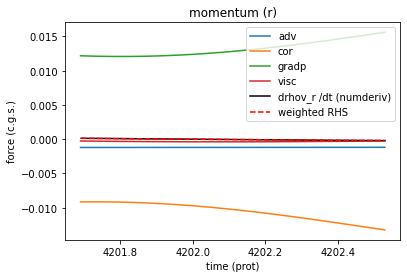

In [16]:
# plot r momentum (all pieces)

# pieces
plt.plot(t, adv_r[iphi0, it0, ir0, :], label='adv')
plt.plot(t, cor_r[iphi0, it0, ir0, :], label='cor')
plt.plot(t, gradp_r[iphi0, it0, ir0, :], label='gradp')
plt.plot(t, visc_r[iphi0, it0, ir0, :], label='visc')

# totals
plt.plot(t[2:], drhovdt_r[iphi0, it0, ir0, :], 'k', label='drhov_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (r)')

Text(0.5, 1.0, 'momentum totals (r)')

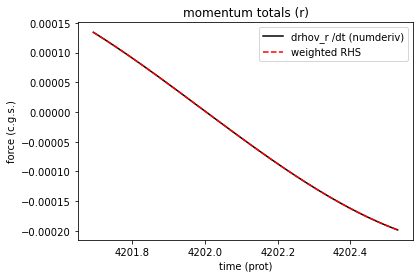

In [17]:
# plot r momentum (totals)
plt.plot(t[2:], drhovdt_r[iphi0, it0, ir0, :], 'k', label='drhov_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (r)')

Text(0.5, 1.0, 'momentum (t)')

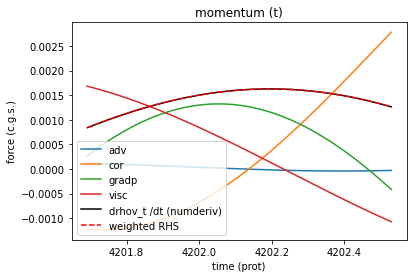

In [18]:
# plot theta momentum (all pieces)

# pieces
plt.plot(t, adv_t[iphi0, it0, ir0, :], label='adv')
plt.plot(t, cor_t[iphi0, it0, ir0, :], label='cor')
plt.plot(t, gradp_t[iphi0, it0, ir0, :], label='gradp')
plt.plot(t, visc_t[iphi0, it0, ir0, :], label='visc')

# totals
plt.plot(t[2:], drhovdt_t[iphi0, it0, ir0, :], 'k', label='drhov_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (t)')

Text(0.5, 1.0, 'momentum totals (t)')

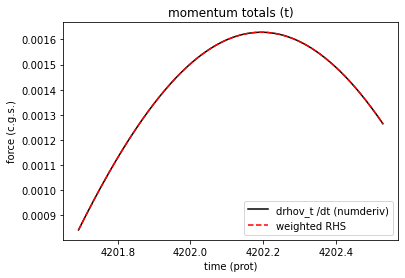

In [19]:
# plot theta momentum (totals)
plt.plot(t[2:], drhovdt_t[iphi0, it0, ir0, :], 'k', label='drhov_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (t)')

Text(0.5, 1.0, 'momentum (p)')

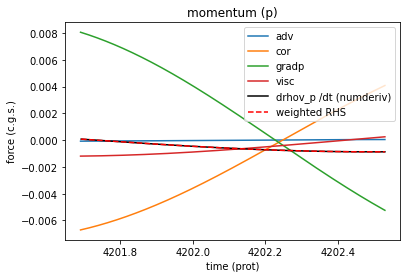

In [20]:
# plot phi momentum (all pieces)

# pieces
plt.plot(t, adv_p[iphi0, it0, ir0, :], label='adv')
plt.plot(t, cor_p[iphi0, it0, ir0, :], label='cor')
plt.plot(t, gradp_p[iphi0, it0, ir0, :], label='gradp')
plt.plot(t, visc_p[iphi0, it0, ir0, :], label='visc')

# totals
plt.plot(t[2:], drhovdt_p[iphi0, it0, ir0, :], 'k', label='drhov_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (p)')

Text(0.5, 1.0, 'momentum totals (p)')

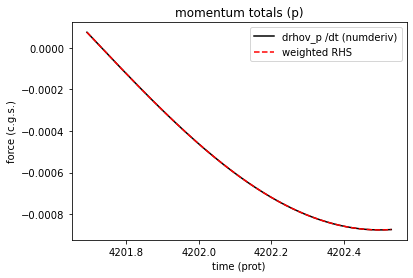

In [21]:
# plot phi momentum (totals)
plt.plot(t[2:], drhovdt_p[iphi0, it0, ir0, :], 'k', label='drhov_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (p)')

Text(0.5, 1.0, 'heat eq.')

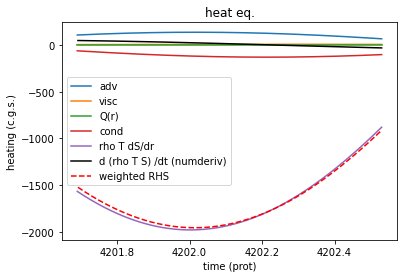

In [22]:
# plot heat equation (all pieces)

# pieces
plt.plot(t, adv_heat[iphi0, it0, ir0, :], label='adv')
plt.plot(t, visc_heat[iphi0, it0, ir0, :], label='visc')
plt.plot(t, int_heat[iphi0, it0, ir0, :], label='Q(r)')
plt.plot(t, cond_heat[iphi0, it0, ir0, :], label='cond')
plt.plot(t, ref_adv_heat[iphi0, it0, ir0, :], label='rho T dS/dr')

# totals
plt.plot(t[2:], dintedt[iphi0, it0, ir0, :], 'k', label='d (rho T S) /dt (numderiv)')
plt.plot(t[2:], fweighted_heat[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('heating (c.g.s.)')
plt.title('heat eq.')

Text(0.5, 1.0, 'heat eq. totals')

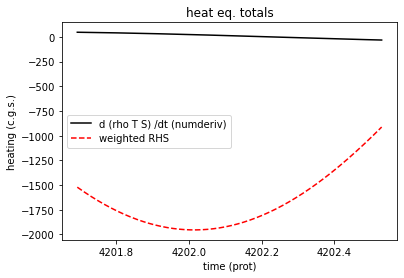

In [23]:
# plot heat equation (totals)

# totals
plt.plot(t[2:], dintedt[iphi0, it0, ir0, :], 'k', label='d (rho T S) /dt (numderiv)')
plt.plot(t[2:], fweighted_heat[iphi0, it0, ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('heating (c.g.s.)')
plt.title('heat eq. totals')

In [24]:
# quantify the numerical errors
def get_err(diff, norm, point=None, ir=None, itheta=None, iphi=None):
    if not point is None:
        iphi, itheta, ir = point
    
    # make everything an array
    if np.isscalar(iphi):
        iphi = np.array([iphi])
    if np.isscalar(itheta):
        itheta = np.array([itheta])
    if np.isscalar(ir):
        ir = np.array([ir])
        
    nphi, ntheta, nr, ntimes = np.shape(diff)
    if iphi is None: # all indices, default
        iphi = np.arange(nphi)
    if itheta is None: # all indices, default
        itheta = np.arange(ntheta)
    if ir is None: # all indices, default
        ir = np.arange(nr)        

    # compute rms via for loop, weight all points (including times) equally
    numer = 0.0
    denom = 0.0
    count = 0
    for iphi_loc in iphi:
        for itheta_loc in itheta:
            for ir_loc in ir:
                for it_loc in range(ntimes):
                    numer += diff[iphi_loc, itheta_loc, ir_loc, it_loc]**2
                    denom += norm[iphi_loc, itheta_loc, ir_loc, it_loc]**2
                    count += 1
    numer /= count
    denom /= count # not that this matters...
    return np.sqrt(numer)/np.sqrt(denom)

In [25]:
# stringent error, at the point we plotted
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, fweighted_r, point=(iphi0, it0, ir0)))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, fweighted_t, point=(iphi0, it0, ir0)))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, fweighted_p, point=(iphi0, it0, ir0)))
print ("err heat  = ", get_err(fweighted_heat - dintedt, fweighted_heat, point=(iphi0, it0, ir0)))

err mom r =  8.167562812122721e-07
err mom t =  4.440906818366615e-07
err mom p =  8.97905547033046e-07
err heat  =  1.0081818324378276


In [26]:
# errors (w.r.t. maxabs) at the point we plotted
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, maxabs_r[2:], point=(iphi0, it0, ir0)))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, maxabs_t[2:], point=(iphi0, it0, ir0)))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, maxabs_p[2:], point=(iphi0, it0, ir0)))
print ("err heat  = ", get_err(fweighted_heat - dintedt, maxabs_heat[2:], point=(iphi0, it0, ir0)))

err mom r =  5.019511091567386e-09
err mom t =  1.2956966567632483e-07
err mom p =  7.172802713352726e-08
err heat  =  1.6160958778843546


In [27]:
# stringent errors over whole shell
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, fweighted_r))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, fweighted_t))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, fweighted_p))
print ("err heat  = ", get_err(fweighted_heat - dintedt, fweighted_heat))

err mom r =  0.00010662586582329529
err mom t =  0.0002558408856232516
err mom p =  0.0001936628796976928
err heat  =  1.0113369935465304


In [28]:
# errors over whole shell (w.r.t. maxabs)
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, maxabs_r[..., 2:]))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, maxabs_t[..., 2:]))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, maxabs_p[..., 2:]))
print ("err heat  = ", get_err(fweighted_heat - dintedt, maxabs_heat[..., 2:]))

err mom r =  1.4350016473327993e-05
err mom t =  4.2490446596453417e-05
err mom p =  1.5985296862337487e-05
err heat  =  0.9999995463234114


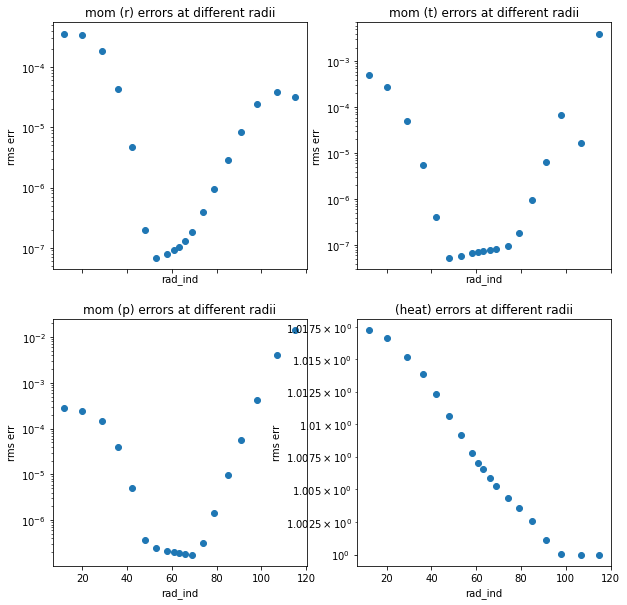

In [37]:
# stringent error at each radius, averaged horizontally, for each equation
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
count = 0
for irow in range(2):
    for icol in range(2):
        if count == 0:
            diff = fweighted_r - drhovdt_r
            fweighted = fweighted_r
            label= 'mom (r)'
        if count == 1:
            diff = fweighted_t - drhovdt_t
            fweighted = fweighted_t
            label= 'mom (t)'
        if count == 2:
            diff = fweighted_p - drhovdt_p
            fweighted = fweighted_p
            label= 'mom (p)'
        if count == 3:
            diff = fweighted_heat - dintedt
            fweighted = fweighted_heat
            label= '(heat)'
            
        errs = []
        for i in range(len(irvals)):
            #print ('ir = %i:' %i, 'err = ', get_err(fweighted_r - drhovdt_r, fweighted_r, ir=i))
            errs.append(get_err(diff, fweighted, ir=i))

        plt.sca(axs[irow, icol])
        plt.scatter(irvals, errs)
        plt.xlabel('rad_ind')
        plt.ylabel('rms err')
        plt.yscale('log')
        plt.title(label + ' errors at different radii')
        count += 1

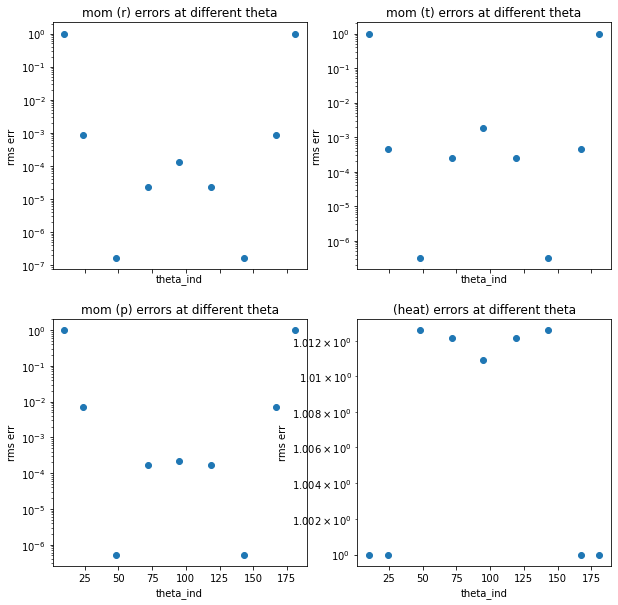

In [39]:
# stringent error at each theta, averaged in r and phi
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
count = 0
for irow in range(2):
    for icol in range(2):
        if count == 0:
            diff = fweighted_r - drhovdt_r
            fweighted = fweighted_r
            label= 'mom (r)'
        if count == 1:
            diff = fweighted_t - drhovdt_t
            fweighted = fweighted_t
            label= 'mom (t)'
        if count == 2:
            diff = fweighted_p - drhovdt_p
            fweighted = fweighted_p
            label= 'mom (p)'
        if count == 3:
            diff = fweighted_heat - dintedt
            fweighted = fweighted_heat
            label= '(heat)'
            
        errs = []
        for i in range(len(ithetavals)):
            #print ('ir = %i:' %i, 'err = ', get_err(fweighted_r - drhovdt_r, fweighted_r, ir=i))
            errs.append(get_err(diff, fweighted, itheta=i))

        plt.sca(axs[irow, icol])
        plt.scatter(ithetavals, errs)
        plt.xlabel('theta_ind')
        plt.ylabel('rms err')
        plt.yscale('log')
        plt.title(label + ' errors at different theta')
        count += 1

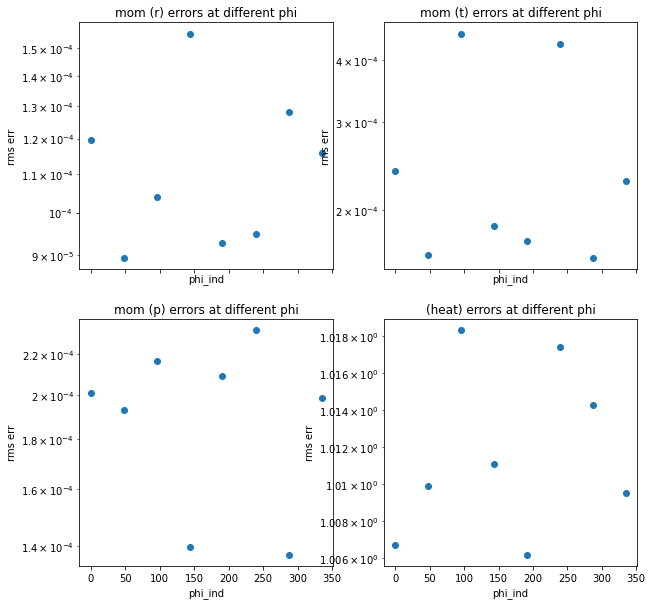

In [40]:
# stringent error at each phi, averaged in meridional planes
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
count = 0
for irow in range(2):
    for icol in range(2):
        if count == 0:
            diff = fweighted_r - drhovdt_r
            fweighted = fweighted_r
            label= 'mom (r)'
        if count == 1:
            diff = fweighted_t - drhovdt_t
            fweighted = fweighted_t
            label= 'mom (t)'
        if count == 2:
            diff = fweighted_p - drhovdt_p
            fweighted = fweighted_p
            label= 'mom (p)'
        if count == 3:
            diff = fweighted_heat - dintedt
            fweighted = fweighted_heat
            label= '(heat)'
            
        errs = []
        for i in range(len(iphivals)):
            #print ('ir = %i:' %i, 'err = ', get_err(fweighted_r - drhovdt_r, fweighted_r, ir=i))
            errs.append(get_err(diff, fweighted, iphi=i))

        plt.sca(axs[irow, icol])
        plt.scatter(iphivals, errs)
        plt.xlabel('phi_ind')
        plt.ylabel('rms err')
        plt.yscale('log')
        plt.title(label + ' errors at different phi')
        count += 1